##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

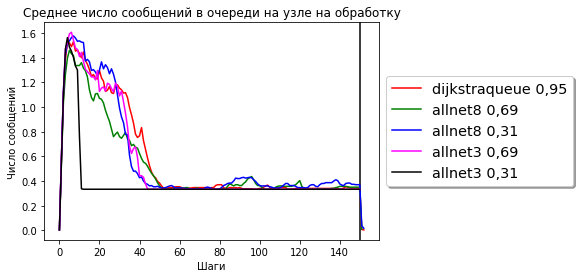

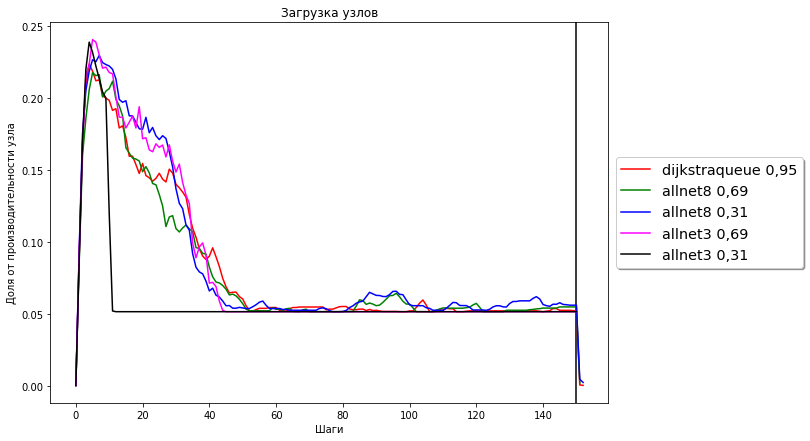

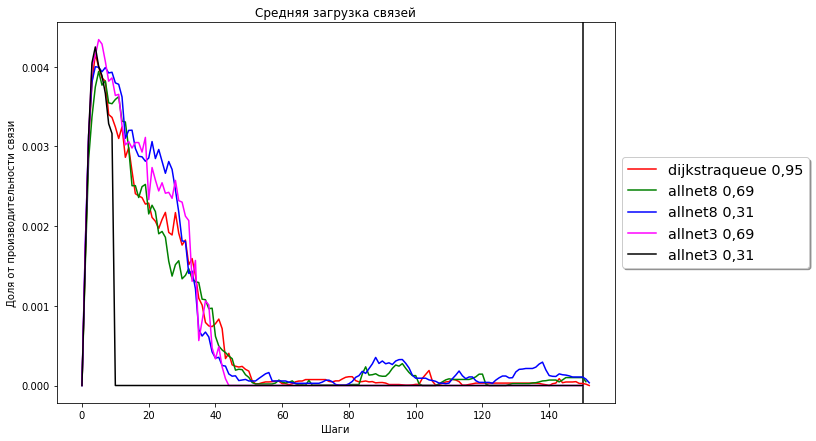

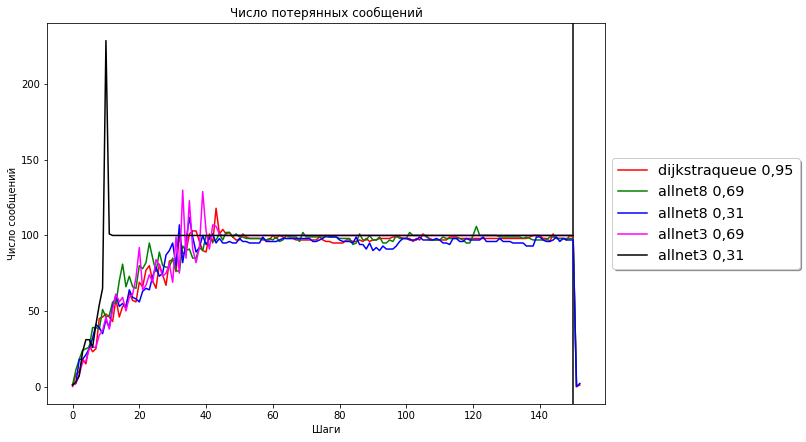

Доставлено 1712 Потеряно 88.5874% -dijkstraqueue 0,95
Доставлено 1492 Потеряно 90.0540% -allnet8 0,69
Доставлено 1871 Потеряно 87.5275% -allnet8 0,31
Доставлено 1414 Потеряно 90.5740% -allnet3 0,69
Доставлено 489 Потеряно 96.7402% -allnet3 0,31


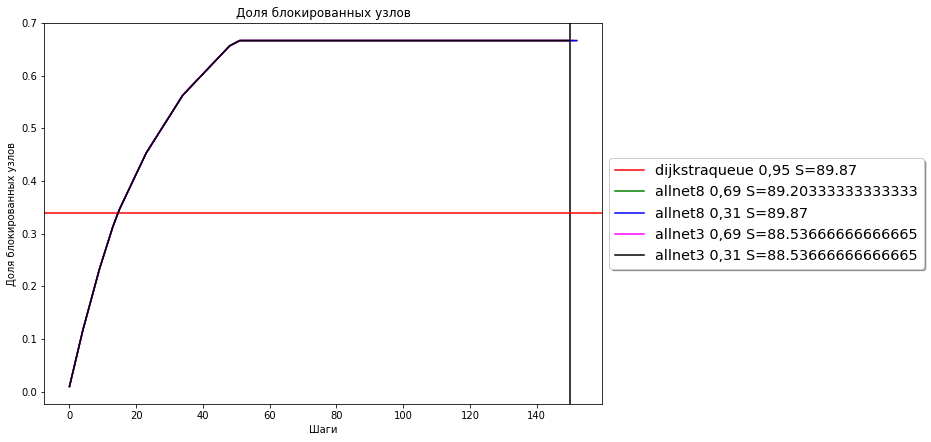

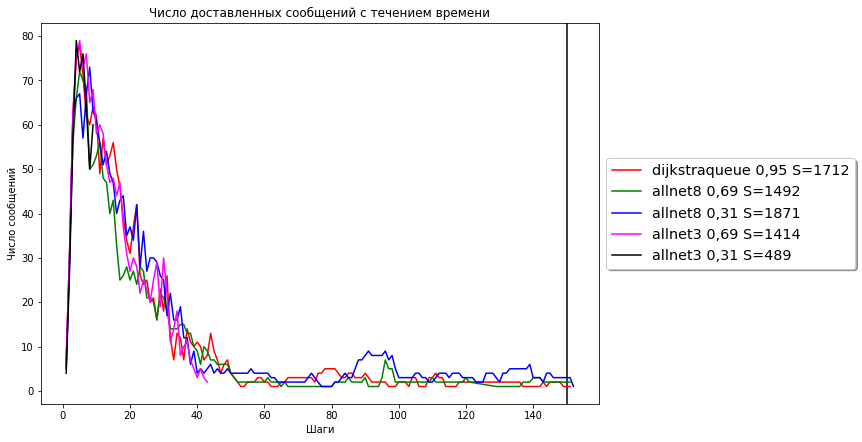

In [2]:
quantity = 100;
log_tags = [
{"tag":  "810d40e1-dfa0-4bb2-93b1-55803e911d57", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "b2d3a788-488a-4e17-83a1-cdaae058758a", "label": "allnet8 0,69", "color": "green"},
{"tag":  "5426ad2d-9722-45f1-a6d4-ccd3a28132bd", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "46bea317-b57d-4f7c-95e7-efa17278a889", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "5c160869-6db1-4940-9eda-a4ed6b5a188c", "label": "allnet3 0,31", "color": "black"},

]
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

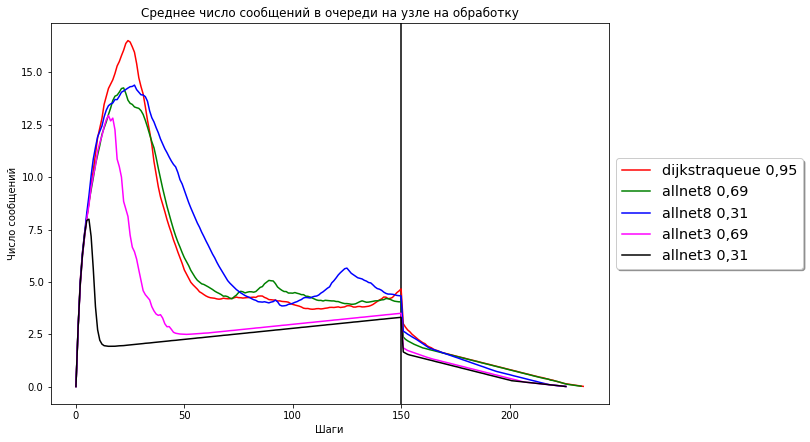

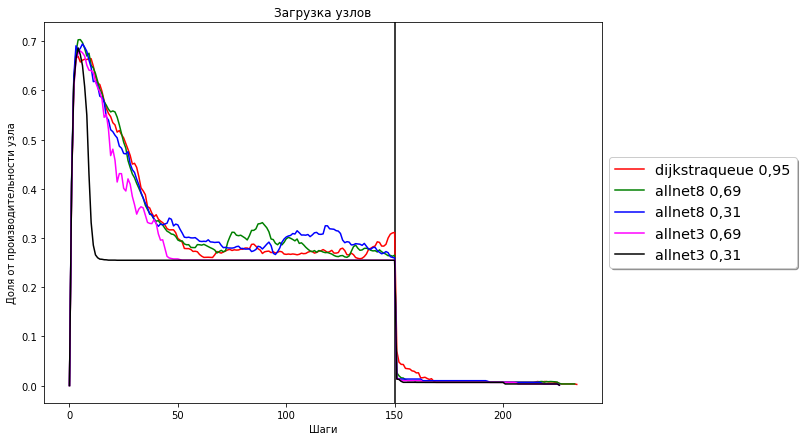

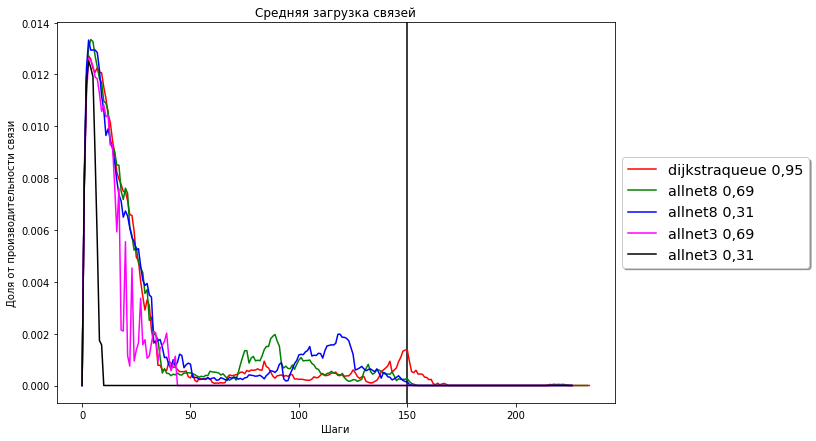

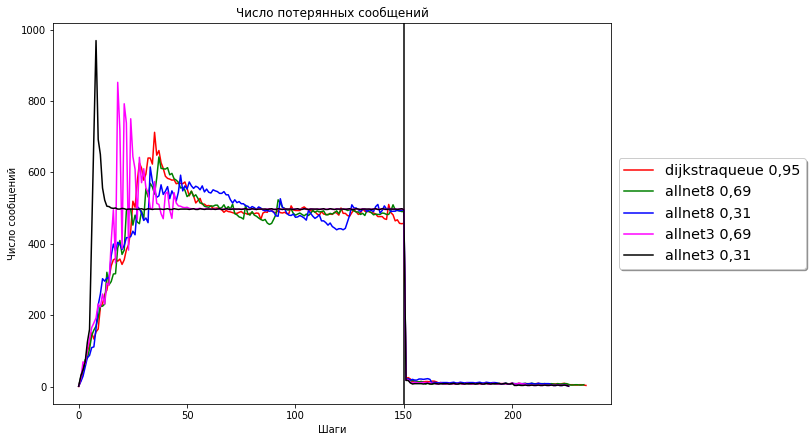

Доставлено 3879 Потеряно 94.8281% -dijkstraqueue 0,95
Доставлено 4576 Потеряно 93.8987% -allnet8 0,69
Доставлено 4304 Потеряно 94.2614% -allnet8 0,31
Доставлено 2627 Потеряно 96.4974% -allnet3 0,69
Доставлено 990 Потеряно 98.6800% -allnet3 0,31


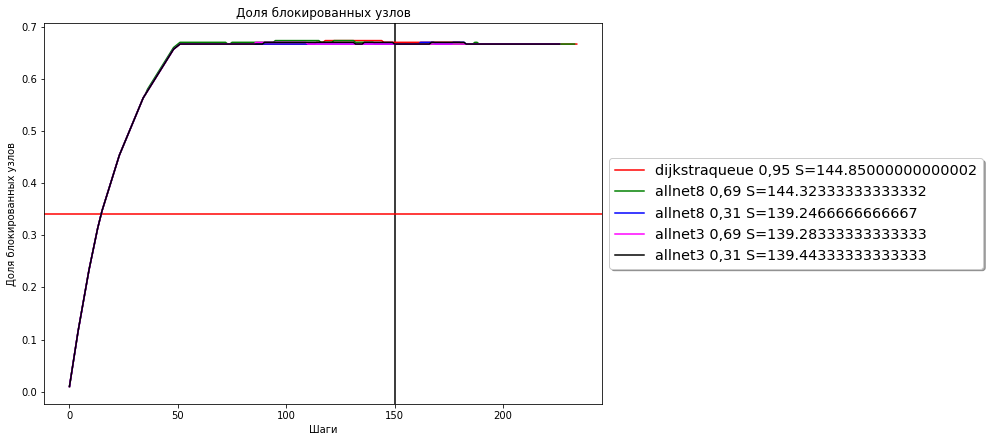

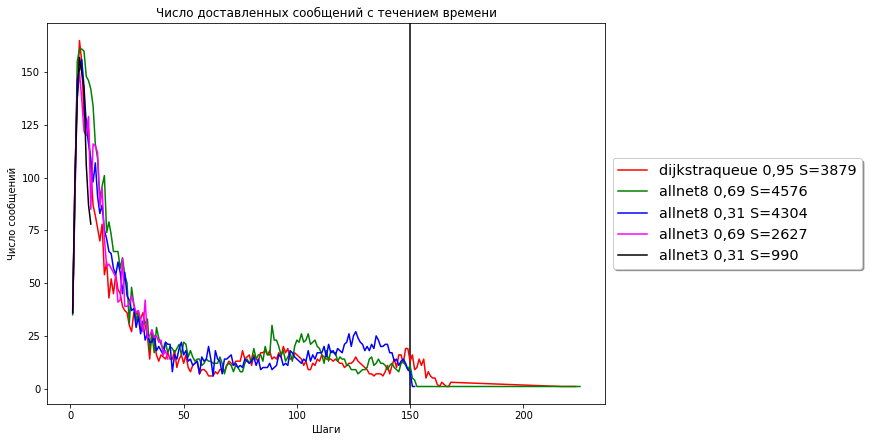

In [3]:
quantity = 500;
log_tags = [
{"tag":  "730abe98-390a-4296-a0dc-6c199dd6a0b9", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "9ae24029-1e9d-4820-b12e-8d260db8b748", "label": "allnet8 0,69", "color": "green"},
{"tag":  "97a69c51-501b-43b8-b9c4-bfe0ef76bae8", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "31a1d957-1f28-4a29-a027-d68fa2e348de", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "c05aec93-a1b1-491d-b32e-b4192e644a38", "label": "allnet3 0,31", "color": "black"},

]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

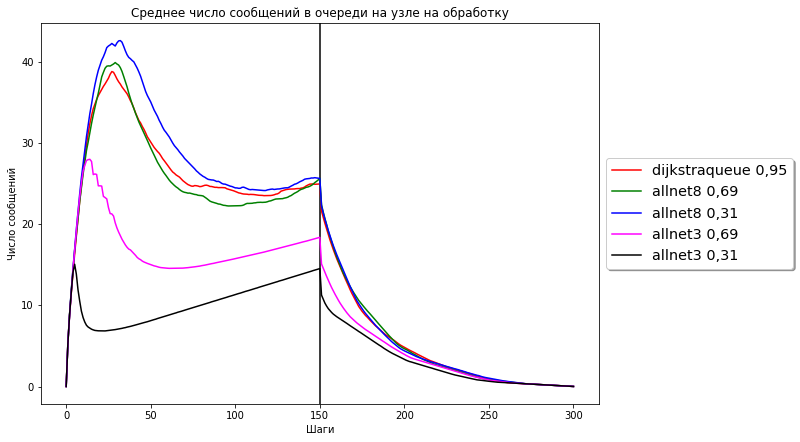

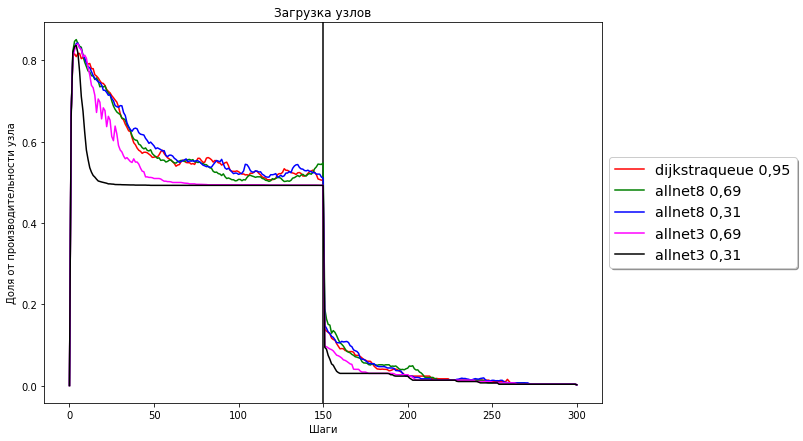

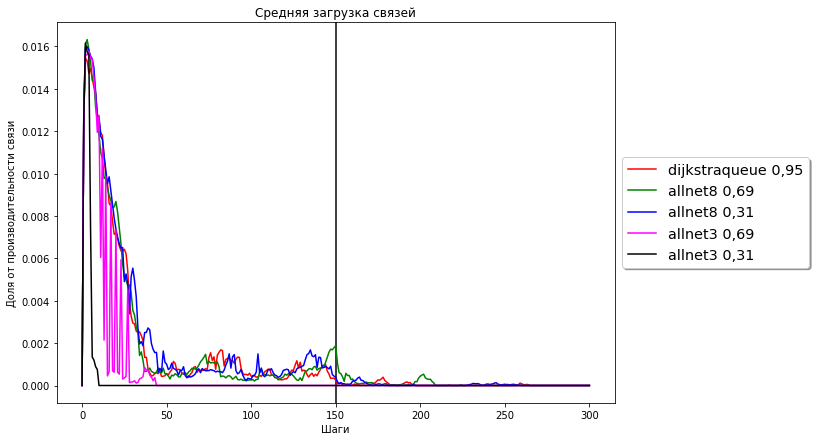

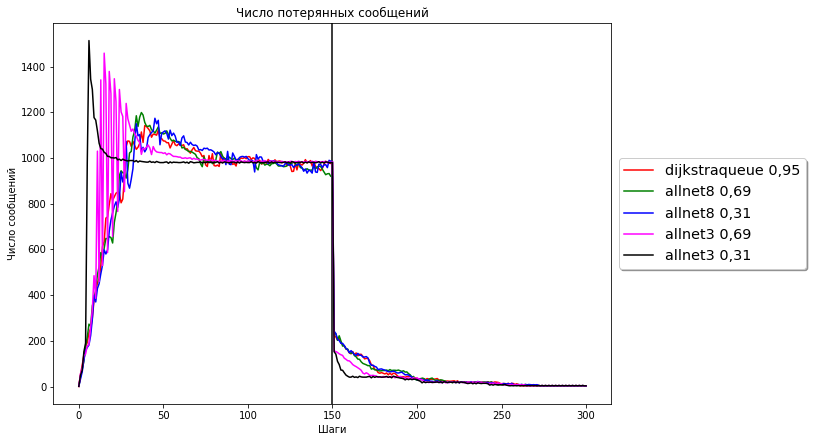

Доставлено 4216 Потеряно 97.1894% -dijkstraqueue 0,95
Доставлено 4659 Потеряно 96.8940% -allnet8 0,69
Доставлено 4593 Потеряно 96.9380% -allnet8 0,31
Доставлено 1714 Потеряно 98.8573% -allnet3 0,69
Доставлено 677 Потеряно 99.5487% -allnet3 0,31


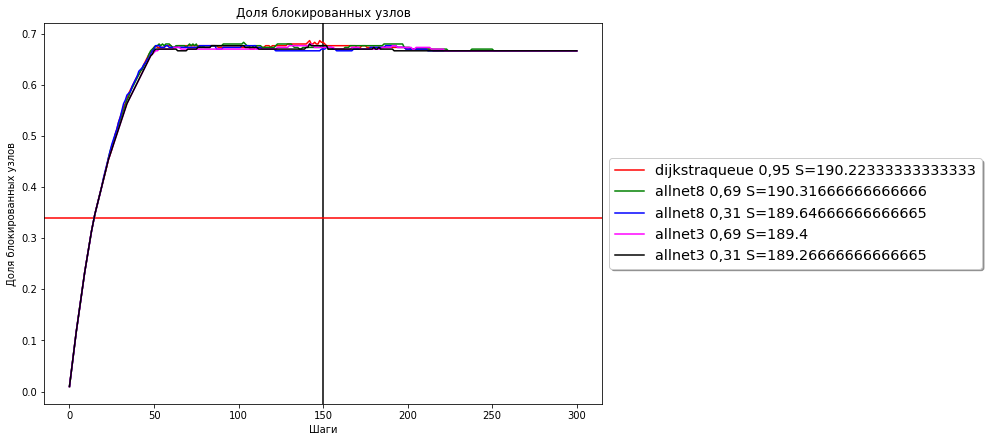

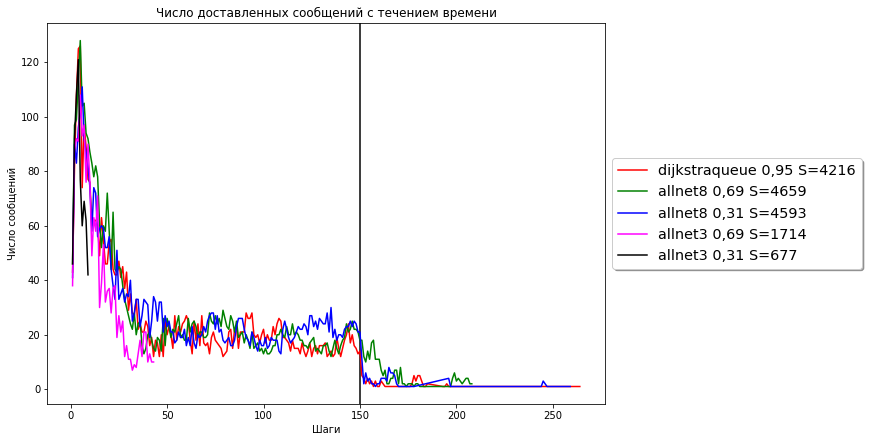

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "d96cc8d8-ab24-4733-bb4a-4b38a3ae6601", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "c10afe13-7050-403b-8cc2-5f2634eed7a0", "label": "allnet8 0,69", "color": "green"},
{"tag":  "cdc5b2a8-37e3-4399-88d1-e52e3341a88d", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "588a0dfe-ada6-4604-8e69-12e2bc623ac7", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "3951a862-1f6d-487d-b3ed-0ffe1abb5f12", "label": "allnet3 0,31", "color": "black"},

]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

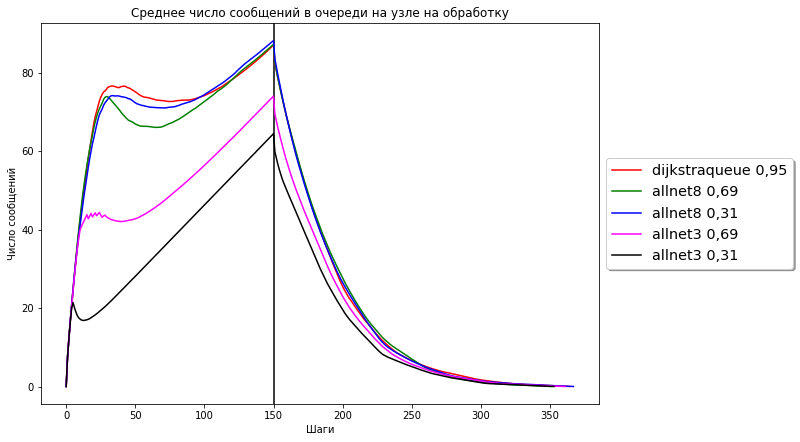

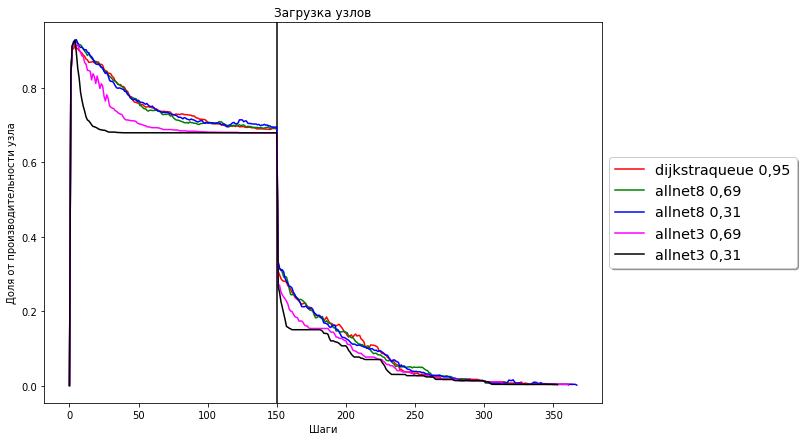

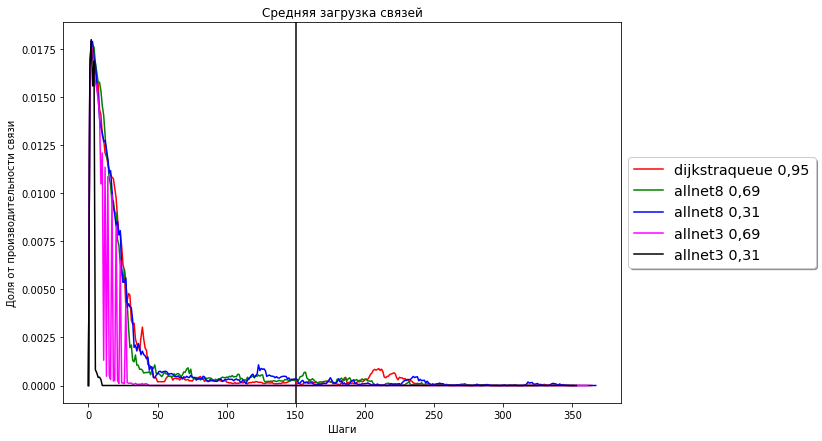

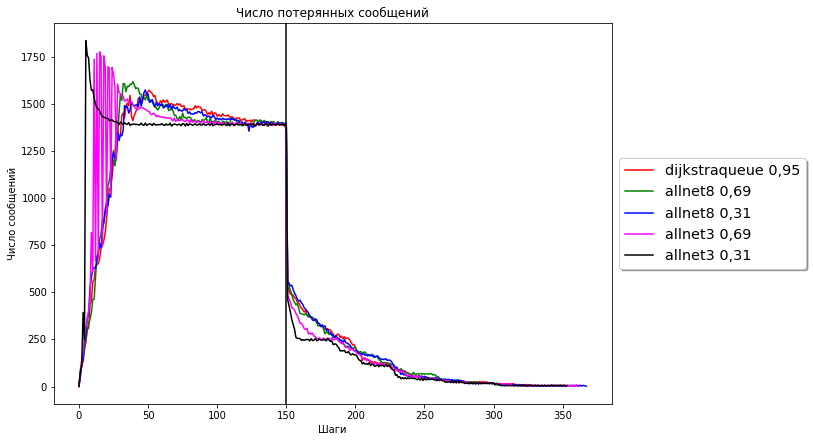

Доставлено 3711 Потеряно 98.3507% -dijkstraqueue 0,95
Доставлено 4406 Потеряно 98.0418% -allnet8 0,69
Доставлено 4074 Потеряно 98.1893% -allnet8 0,31
Доставлено 1357 Потеряно 99.3969% -allnet3 0,69
Доставлено 469 Потеряно 99.7916% -allnet3 0,31


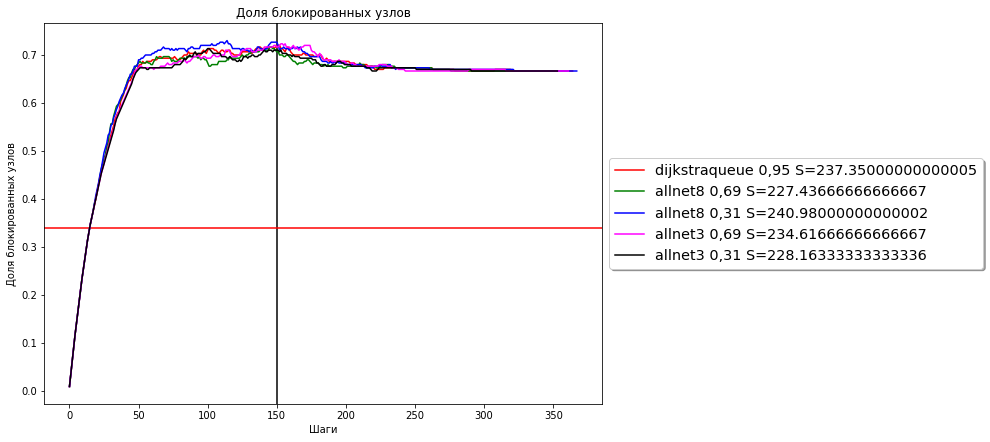

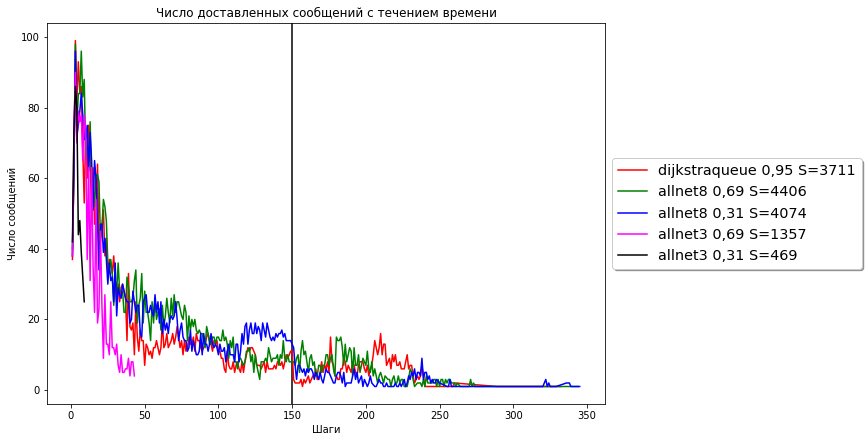

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "b8051230-ab9b-4356-8444-f53f9064d962", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "90dacfd9-ffa0-433b-b1d8-22895c1eafe5", "label": "allnet8 0,69", "color": "green"},
{"tag":  "70ee20b4-ff7a-4ed8-9193-db6cddf066e8", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "c0aa3bbd-5a95-478a-901f-6743a9a2dd21", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "7d19f4bd-c0f5-4e89-9157-140e0687cde4", "label": "allnet3 0,31", "color": "black"},

] 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 4069 Потеряно 90.9580% -dijkstraqueue 0,95
Доставлено 3483 Потеряно 92.2602% -allnet8 0,69
Доставлено 3872 Потеряно 91.3957% -allnet8 0,31
Доставлено 2996 Потеряно 93.3424% -allnet3 0,69
Доставлено 1053 Потеряно 97.6601% -allnet3 0,31


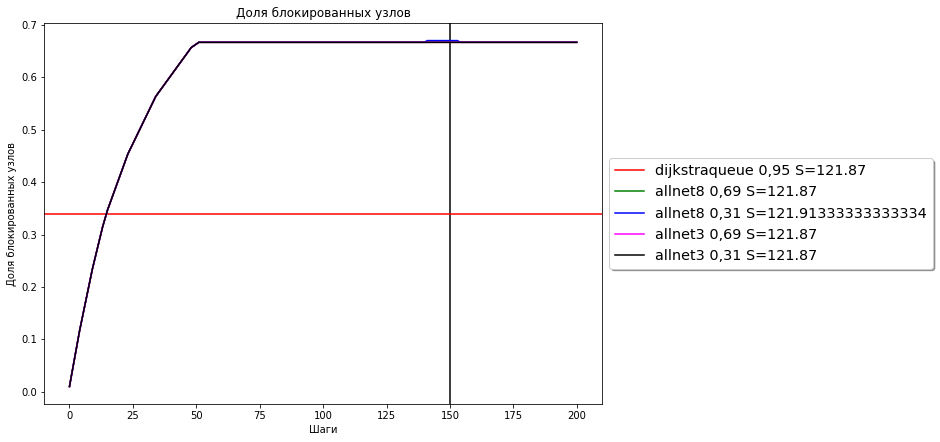

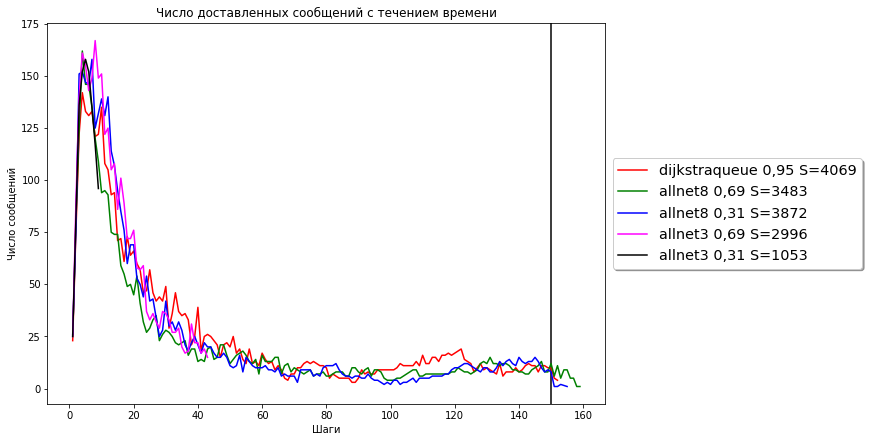

Доставлено 4683 Потеряно 95.5400% -dijkstraqueue 0,95
Доставлено 4677 Потеряно 95.5458% -allnet8 0,69
Доставлено 4647 Потеряно 95.5743% -allnet8 0,31
Доставлено 2464 Потеряно 97.6534% -allnet3 0,69
Доставлено 832 Потеряно 99.2076% -allnet3 0,31


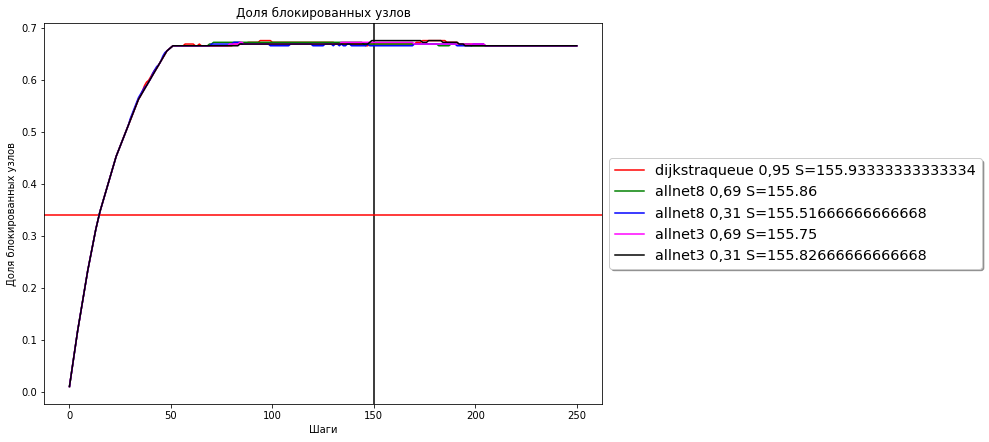

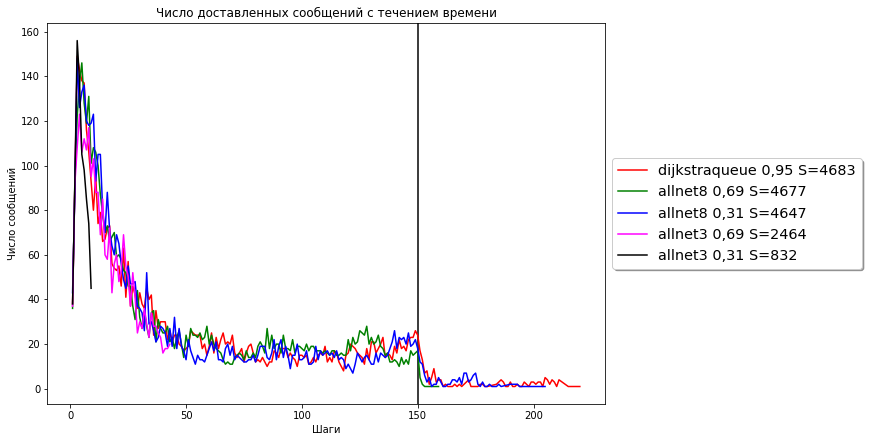

Доставлено 3934 Потеряно 97.0859% -dijkstraqueue 0,95
Доставлено 4387 Потеряно 96.7504% -allnet8 0,69
Доставлено 5025 Потеряно 96.2778% -allnet8 0,31
Доставлено 2174 Потеряно 98.3896% -allnet3 0,69
Доставлено 719 Потеряно 99.4674% -allnet3 0,31


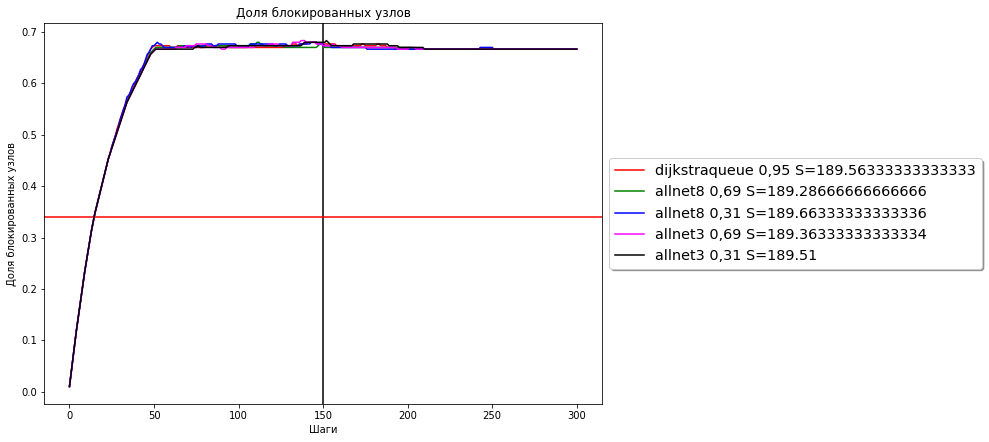

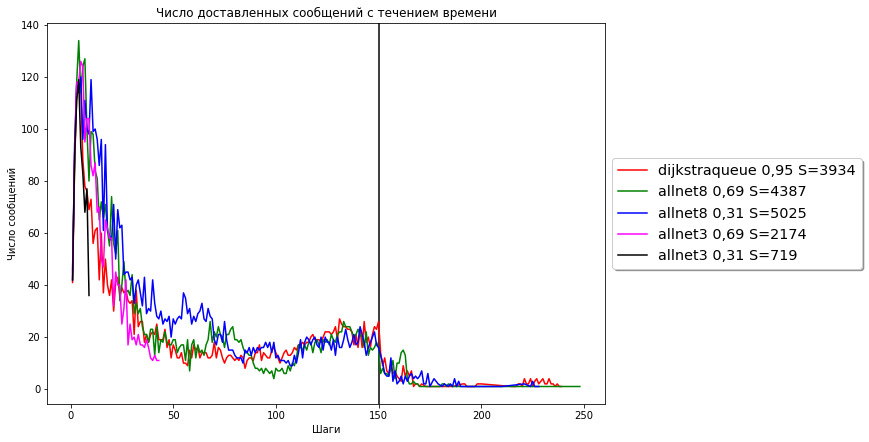

Доставлено 4463 Потеряно 97.7113% -dijkstraqueue 0,95
Доставлено 4903 Потеряно 97.4857% -allnet8 0,69
Доставлено 5041 Потеряно 97.4149% -allnet8 0,31
Доставлено 1838 Потеряно 99.0574% -allnet3 0,69
Доставлено 474 Потеряно 99.7569% -allnet3 0,31


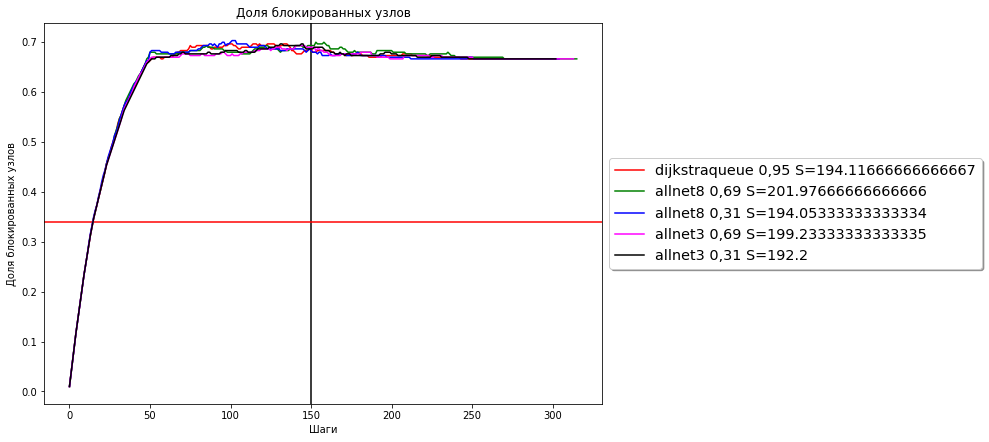

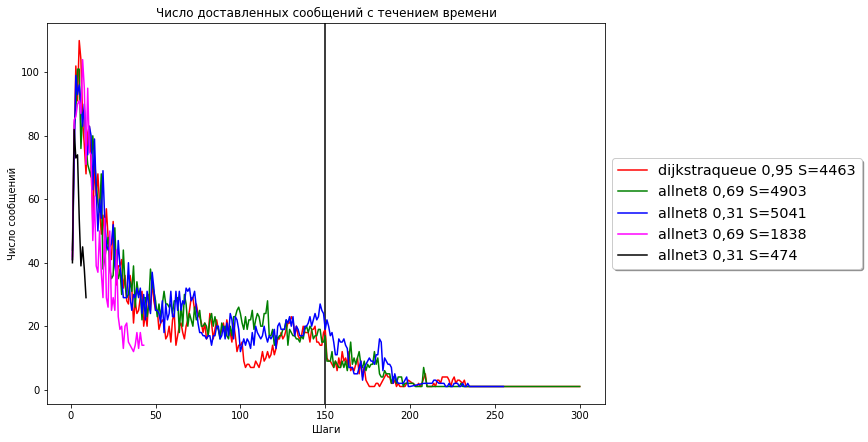

In [6]:
quantity = 300;
log_tags = [
{"tag":  "7a73016e-9eaa-4ec9-a728-9216931e86c8", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "b345211b-bb9e-4bb1-883a-b14546f70f24", "label": "allnet8 0,69", "color": "green"},
{"tag":  "cd8c06aa-9ef5-430b-89ed-1c262c32106c", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "a3a07b24-1e75-42f4-ba6d-bdc878b03563", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "1a4a353d-1fab-40aa-b6e4-4fd0e3035c28", "label": "allnet3 0,31", "color": "black"},

]
showStatBlocked();  
showStatMessage();
quantity = 700;
log_tags = [
{"tag":  "a8e31c30-71cd-4b1e-ba85-5e7b16fe4966", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "5e513d14-c9d6-436b-bcb4-9ef3e9225e23", "label": "allnet8 0,69", "color": "green"},
{"tag":  "272a52d3-8020-400a-ae45-f6835cf127fa", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "7b5a2578-2fc6-4ddd-8353-8ad76d551297", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "02ae85b3-93fa-47af-a8c5-665a6d65a4c3", "label": "allnet3 0,31", "color": "black"},

]
showStatBlocked();  
showStatMessage();
quantity = 900;
log_tags = [
{"tag":  "20193f44-acb4-4fbb-a21c-0e2f083da46e", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "b302bf7b-9334-469b-9c75-50d6c20c2811", "label": "allnet8 0,69", "color": "green"},
{"tag":  "07a83564-9fcb-4ecc-9059-5365009e9404", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "95eddf81-754f-4c14-b3ee-240752146a69", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "db60ad74-66d8-409d-8ac0-c65d95f8ebc0", "label": "allnet3 0,31", "color": "black"},

]
showStatBlocked();  
showStatMessage();
quantity = 1300;
log_tags = [
{"tag":  "cd169fe1-9fc3-406d-a6b6-dc53d1bc881d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "abfebfcb-76f0-47d9-990a-5849d772523e", "label": "allnet8 0,69", "color": "green"},
{"tag":  "6b167a5c-41eb-4778-8474-0623b7122e06", "label": "allnet8 0,31", "color": "blue"},
{"tag":  "eb4b249b-6f18-4363-a4ca-dec4b83210de", "label": "allnet3 0,69", "color": "magenta"},
{"tag":  "917ffdea-2de8-40eb-b3b2-375136c8e1d7", "label": "allnet3 0,31", "color": "black"},

]
showStatBlocked();  
showStatMessage();

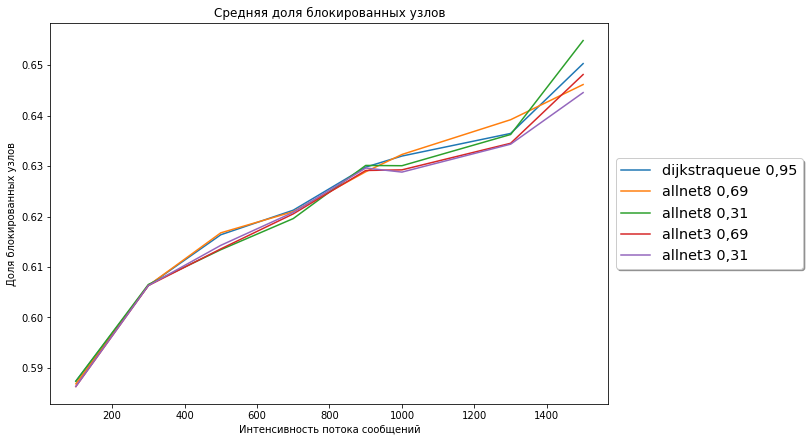

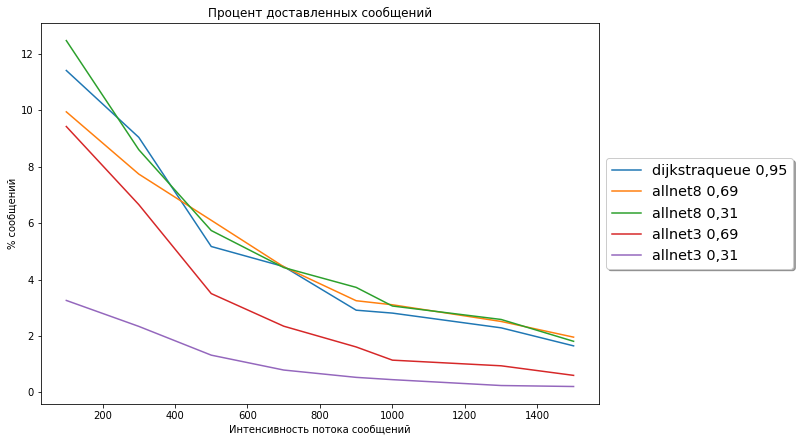

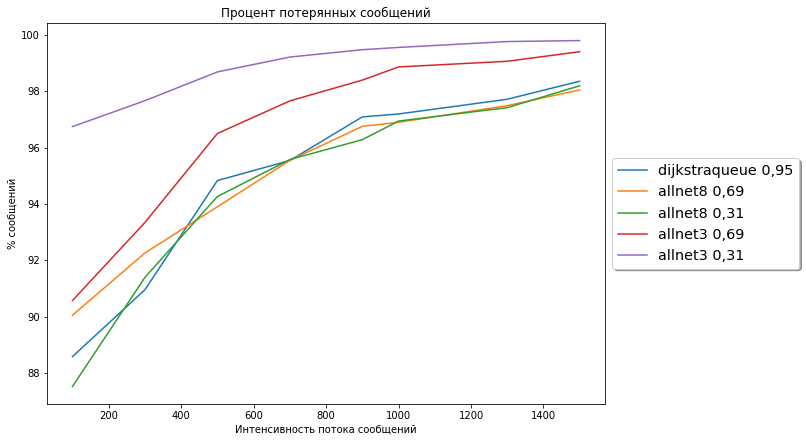

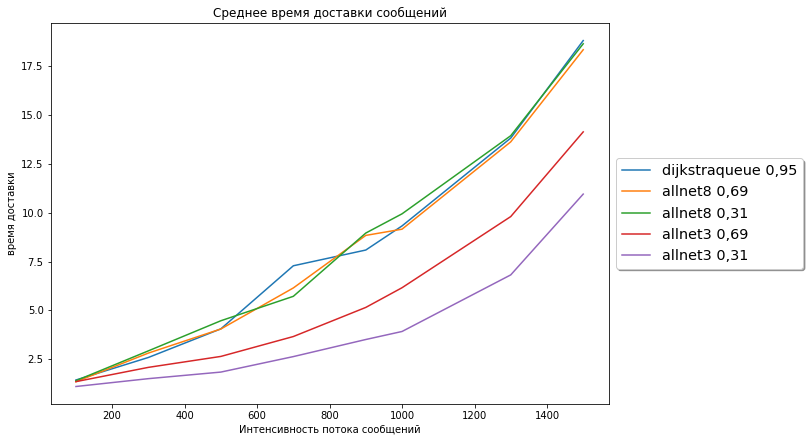

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

dijkstraqueue 0,95    0.622476
allnet8 0,69          0.622167
allnet8 0,31          0.622272
allnet3 0,69          0.620965
allnet3 0,31          0.620626

dijkstraqueue 0,95    95.031348
allnet8 0,69          95.116316
allnet8 0,31          94.697379
allnet3 0,69          96.721048
allnet3 0,31          98.856559

dijkstraqueue 0,95    8.175076
allnet8 0,69          8.038888
allnet8 0,31          8.250118
allnet3 0,69          5.618954
allnet3 0,31          4.028183
